# Úkol č. 3 - shlukování

- **Deadline je do 28. 12. 2022, 23:59:59**, pokud odevzdáte úkol do 4. 1. 2023, 23:59:59, budete penalizování -4 body, pozdější odevzdání je bez bodu.
- V rámci tohoto úkolu se musíte vypořádat s problematikou shlukování.

> **Úkoly jsou zadány tak, aby Vám daly prostor pro invenci. Vymyslet _jak přesně_ budete úkol řešit, je důležitou součástí zadání a originalita či nápaditost bude také hodnocena!**

Využívejte buňky typu `Markdown` k vysvětlování Vašeho postupu. Za nepřehlednost budeme strhávat body.

## Zdroj dat

- Zdrojem dat je soubor `CC GENERAL.csv` (originál zde: https://www.kaggle.com/datasets/arjunbhasin2013/ccdata).
- Popis datasetu najdete v souboru `data_description.txt`.

## Pokyny k vypracování

**Body zadání**, za jejichž (poctivé) vypracování získáte **16 bodů**:

- Proveďte základní průzkum dat a svá pozorování diskutujte. Na jeho základě adekvátně reagujte na problematické věci v datech (chybějící hodnoty, atd.) a vysvětlete motivaci k provedeným krokům.
- Vytvořte **vlastní implementaci** algoritmu KMeans.
- Pomocí této vlastní implementace proveďte shlukování.
- Zopakujte shlukování s implementací `sklearn.cluster.KMeans`. Pokuste se sladit hyperparametry tak, abyste dostali stejné výsledky. Pokud se Vám to nepovede, diskutujte proč.
- Pokuste se odhadnout vhodný počet shluků (např. metodou lokte).
- Proveďte také aglomerativní hierarchické shlukování (použijte existující implementaci) a nakreslete dendrogram (resp. alespoň jeho vhodnou horní část).
- Zopakujte předchozí kroky a při tom experimentujte s různými hodnotami hyperparametrů a také se standardizací/normalizací dat.
  - Kvalitu vytvořených shluků můžete analyzovat pomocí metody Silhouette (https://en.wikipedia.org/wiki/Silhouette_(clustering)).
- Cílem je vybrat shlukování, které Vám přijde nejlepší (můžete přihlédnout k následujícímu bodu). Popište, proč jste ho vybrali.
- Na tomto vybraném shlukování se pokuste interpretovat výsledné shluky.
  - Snažte se identifikovat a popsat typy uživatelů kreditních karet podle Vámi zvolených vybraných kritérií. Můžete přitom koukat například na BALANCE, PURCHASES, CASH_ADVANCE, PAYMENTS, atd.

## Poznámky k odevzdání

- Řiďte se pokyny ze stránky https://courses.fit.cvut.cz/BI-ML1/homeworks/index.html.
- Opravující Vám ve výjimečných případech může umožnit úkol dodělat či opravit a získat tak další body. První verze je ale stěžejní a má hlavní vliv na hodnocení.


==========================================================================================================================================================

To be honest, this homework is probably my worst yet. I'm tired and in severe need of an extended break. So I'm sorry if you see something subpar or even straight-up stupid here.

In [173]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from scipy import optimize
from sklearn.impute import KNNImputer
from scipy.cluster.hierarchy import linkage, dendrogram
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from yellowbrick.cluster import KElbowVisualizer, SilhouetteVisualizer
from sklearn.decomposition import PCA
import random
from numpy.random import uniform

np.set_printoptions(precision=5, suppress=True)


In [174]:
df = pd.read_csv("CC GENERAL.csv")
display(df.head())
df.info()
display(df.isnull().sum())
df.describe()


,CUST_ID,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,C10001,40.900749,0.818182,95.40,0.00,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0,2,1000.0,201.802084,139.509787,0.000000,12
1,C10002,3202.467416,0.909091,0.00,0.00,0.0,6442.945483,0.000000,0.000000,0.000000,0.250000,4,0,7000.0,4103.032597,1072.340217,0.222222,12
2,C10003,2495.148862,1.000000,773.17,773.17,0.0,0.000000,1.000000,1.000000,0.000000,0.000000,0,12,7500.0,622.066742,627.284787,0.000000,12
3,C10004,1666.670542,0.636364,1499.00,1499.00,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1,1,7500.0,0.000000,NaN,0.000000,12
4,C10005,817.714335,1.000000,16.00,16.00,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0,1,1200.0,678.334763,244.791237,0.000000,12


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8950 entries, 0 to 8949
Data columns (total 18 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   CUST_ID                           8950 non-null   object 
 1   BALANCE                           8950 non-null   float64
 2   BALANCE_FREQUENCY                 8950 non-null   float64
 3   PURCHASES                         8950 non-null   float64
 4   ONEOFF_PURCHASES                  8950 non-null   float64
 5   INSTALLMENTS_PURCHASES            8950 non-null   float64
 6   CASH_ADVANCE                      8950 non-null   float64
 7   PURCHASES_FREQUENCY               8950 non-null   float64
 8   ONEOFF_PURCHASES_FREQUENCY        8950 non-null   float64
 9   PURCHASES_INSTALLMENTS_FREQUENCY  8950 non-null   float64
 10  CASH_ADVANCE_FREQUENCY            8950 non-null   float64
 11  CASH_ADVANCE_TRX                  8950 non-null   int64  
 12  PURCHA

CUST_ID                               0
BALANCE                               0
BALANCE_FREQUENCY                     0
PURCHASES                             0
ONEOFF_PURCHASES                      0
INSTALLMENTS_PURCHASES                0
CASH_ADVANCE                          0
PURCHASES_FREQUENCY                   0
ONEOFF_PURCHASES_FREQUENCY            0
PURCHASES_INSTALLMENTS_FREQUENCY      0
CASH_ADVANCE_FREQUENCY                0
CASH_ADVANCE_TRX                      0
PURCHASES_TRX                         0
CREDIT_LIMIT                          1
PAYMENTS                              0
MINIMUM_PAYMENTS                    313
PRC_FULL_PAYMENT                      0
TENURE                                0
dtype: int64

,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
count,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8950.000000,8949.000000,8950.000000,8637.000000,8950.000000,8950.000000
mean,1564.474828,0.877271,1003.204834,592.437371,411.067645,978.871112,0.490351,0.202458,0.364437,0.135144,3.248827,14.709832,4494.449450,1733.143852,864.206542,0.153715,11.517318
std,2081.531879,0.236904,2136.634782,1659.887917,904.338115,2097.163877,0.401371,0.298336,0.397448,0.200121,6.824647,24.857649,3638.815725,2895.063757,2372.446607,0.292499,1.338331
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,50.000000,0.000000,0.019163,0.000000,6.000000
25%,128.281915,0.888889,39.635000,0.000000,0.000000,0.000000,0.083333,0.000000,0.000000,0.000000,0.000000,1.000000,1600.000000,383.276166,169.123707,0.000000,12.000000
50%,873.385231,1.000000,361.280000,38.000000,89.000000,0.000000,0.500000,0.083333,0.166667,0.000000,0.000000,7.000000,3000.000000,856.901546,312.343947,0.000000,12.000000
75%,2054.140036,1.000000,1110.130000,577.405000,468.637500,1113.821139,0.916667,0.300000,0.750000,0.222222,4.000000,17.000000,6500.000000,1901.134317,825.485459,0.142857,12.000000
max,19043.138560,1.000000,49039.570000,40761.250000,22500.000000,47137.211760,1.000000,1.000000,1.000000,1.500000,123.000000,358.000000,30000.000000,50721.483360,76406.207520,1.000000,12.000000


Since this is just a custom ID, I'll drop it.

In [175]:
df.drop(['CUST_ID'], axis=1, inplace=True)


I get rid of outliers as I assume they would interfere with the clusters too much.

In [176]:
for column in df.columns:
    data = df[column]

    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    minimum = Q1 - (1.5 * IQR)
    maximum = Q3 + (1.5 * IQR)

    outliers = ((data < minimum) | (data > maximum))
    df[column].loc[outliers] = np.nan


C:\Users\Brumda\AppData\Local\Temp\ipykernel_7780\3459515004.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[column].loc[outliers] = np.nan


In [177]:
display(df.isnull().sum())


BALANCE                              695
BALANCE_FREQUENCY                   1493
PURCHASES                            808
ONEOFF_PURCHASES                    1013
INSTALLMENTS_PURCHASES               867
CASH_ADVANCE                        1030
PURCHASES_FREQUENCY                    0
ONEOFF_PURCHASES_FREQUENCY           782
PURCHASES_INSTALLMENTS_FREQUENCY       0
CASH_ADVANCE_FREQUENCY               525
CASH_ADVANCE_TRX                     804
PURCHASES_TRX                        766
CREDIT_LIMIT                         249
PAYMENTS                             808
MINIMUM_PAYMENTS                    1154
PRC_FULL_PAYMENT                    1474
TENURE                              1366
dtype: int64

I don't want to drop all the outliers, so I replace them alongside the initial nan values using KNN Imputer

In [178]:
imputer = KNNImputer()
imp_data = pd.DataFrame(imputer.fit_transform(df), columns=df.columns)
imp_data.isna().sum()


BALANCE                             0
BALANCE_FREQUENCY                   0
PURCHASES                           0
ONEOFF_PURCHASES                    0
INSTALLMENTS_PURCHASES              0
CASH_ADVANCE                        0
PURCHASES_FREQUENCY                 0
ONEOFF_PURCHASES_FREQUENCY          0
PURCHASES_INSTALLMENTS_FREQUENCY    0
CASH_ADVANCE_FREQUENCY              0
CASH_ADVANCE_TRX                    0
PURCHASES_TRX                       0
CREDIT_LIMIT                        0
PAYMENTS                            0
MINIMUM_PAYMENTS                    0
PRC_FULL_PAYMENT                    0
TENURE                              0
dtype: int64

In [179]:
df = imp_data
df.head()


,BALANCE,BALANCE_FREQUENCY,PURCHASES,ONEOFF_PURCHASES,INSTALLMENTS_PURCHASES,CASH_ADVANCE,PURCHASES_FREQUENCY,ONEOFF_PURCHASES_FREQUENCY,PURCHASES_INSTALLMENTS_FREQUENCY,CASH_ADVANCE_FREQUENCY,CASH_ADVANCE_TRX,PURCHASES_TRX,CREDIT_LIMIT,PAYMENTS,MINIMUM_PAYMENTS,PRC_FULL_PAYMENT,TENURE
0,40.900749,0.818182,95.40,0.000,95.4,0.000000,0.166667,0.000000,0.083333,0.000000,0.0,2.0,1000.0,201.802084,139.509787,0.000000,12.0
1,3202.467416,0.909091,0.00,0.000,0.0,1068.127248,0.000000,0.000000,0.000000,0.250000,4.0,0.0,7000.0,4103.032597,1072.340217,0.222222,12.0
2,2495.148862,1.000000,773.17,773.170,0.0,0.000000,1.000000,0.650000,0.000000,0.000000,0.0,12.0,7500.0,622.066742,627.284787,0.000000,12.0
3,1666.670542,0.981818,1499.00,309.918,0.0,205.788017,0.083333,0.083333,0.000000,0.083333,1.0,1.0,7500.0,0.000000,1112.028902,0.000000,12.0
4,817.714335,1.000000,16.00,16.000,0.0,0.000000,0.083333,0.083333,0.000000,0.000000,0.0,1.0,1200.0,678.334763,244.791237,0.000000,12.0


My implementation of Kmeans with parts I found on the internet. It should work, although sometimes it doesn't find the best centroids

In [180]:
class My_KMeans:
    def __init__(self, n_clusters=8, max_iter=300, tol=1e-4):
        self.n_clusters = n_clusters
        self.max_iter = max_iter
        self.tol = tol
        self.centroids_prev = []
        

    def fit(self, X):
        n_samples, n_features = X.shape

        # Initialize cluster centers randomly
        self.centers = X[np.random.choice(
            n_samples-1, self.n_clusters, replace=False)]

        # Initialize cluster labels for each sample to -1
        self.labels = np.full(n_samples, -1, dtype=int)

        # Iterate until convergence or maximum number of iterations is reached
        for _ in range(self.max_iter):
            # Calculate distance between each sample and cluster centers with some dark magic I found on the internet
            distances = np.sqrt(
                np.sum((X[:, np.newaxis, :] - self.centers)**2, axis=-1))

            # Assign samples to nearest cluster center
            self.labels = np.argmin(distances, axis=1)

            # Check for convergence
            if len(self.centroids_prev) > 0 and np.abs(self.centers - self.centroids_prev).max() < self.tol:
                break

            self.centroids_prev = self.centers

            # Calculate new cluster centers as mean of samples assigned to each cluster
            for j in range(self.n_clusters):
                points = X[self.labels == j]
                if len(points) > 0:
                    self.centers[j] = points.mean(axis=0)


In [181]:
df1 = df.to_numpy()


In [182]:
my_kmeans = My_KMeans()
my_kmeans.fit(df1)


In [183]:
kmeans = KMeans(n_clusters=8, random_state=1).fit(df1)
print(kmeans.cluster_centers_[0])


[3363.76468    0.98766  613.19677  245.72948  194.8983   974.72813
    0.40642    0.18002    0.28671    0.21237    3.56877    9.92602
 6324.28571 1697.76677 1090.37508    0.01185   12.     ]


In [184]:
print(my_kmeans.centers[0])


[ 540.5021     0.97243  406.96875  195.14109  183.92398  198.47172
    0.44976    0.15167    0.29252    0.04746    0.76021    8.19281
 6805.03793  583.79278  315.64304    0.03428   12.     ]


As you can see here and below, the centroids my function chose are somewhat close to the sklearn ones, but they are almost always different in some dimension

In [185]:
def list_compare(a, b, tol):
    for i in range(len(a)):
        for j in range(len(a[i])):
            if np.abs(a[i][j] - b[i][j]) > tol:
                return False
    return True


display(list_compare(kmeans.cluster_centers_, my_kmeans.centers, 10))
(kmeans.labels_ == my_kmeans.labels).all()


False

False

In [186]:
for k in range(1, 20):
    my_kmeans = My_KMeans(k)
    my_kmeans.fit(df1)
    kmeans = KMeans(n_clusters=k, random_state=1).fit(df1)
    if list_compare(kmeans.cluster_centers_, my_kmeans.centers, 10):
        print(f"Close enough with k = {k}")
        print(
            f"Labels match aswell = {(kmeans.labels_ == my_kmeans.labels).all()}")


Close enough with k = 1
Labels match aswell = True


I tried normalization/scaling the data using a standard scaler, min-max and PCA. The one time I get close to the scikit version is when I use just one cluster. That makes me believe that my implementation somewhat works since it finds the same centroid if it has to find just one. There could be a problem with the randomization of the initial centroids (I'm not using k-means++, nor do I choose the initial centroids manually), or my code could be just a pile of garbage, as I never rule out that option.

In [187]:
std_scaled = pd.DataFrame(StandardScaler().fit_transform(df), columns=df.columns)
mm_scaled = pd.DataFrame(MinMaxScaler().fit_transform(df), columns=df.columns)


In [188]:
pca = PCA(n_components=0.85, random_state=42)
pca.fit(df)
PC_names = ['PC'+str(x) for x in range(1,len(pca.components_)+1)]
pca_data = pd.DataFrame(pca.transform(df), columns=PC_names)

In [189]:
for k in range(1, 20):
    my_kmeans = My_KMeans(k)
    my_kmeans.fit(std_scaled.to_numpy())
    kmeans = KMeans(n_clusters=k, random_state=1).fit(std_scaled.to_numpy())
    if list_compare(kmeans.cluster_centers_, my_kmeans.centers, .01):
        print(f"Close enough with k = {k}")
        print(
            f"Labels match aswell = {(kmeans.labels_ == my_kmeans.labels).all()}")


Close enough with k = 1
Labels match aswell = True


In [190]:
for k in range(1, 20):
    my_kmeans = My_KMeans(k)
    my_kmeans.fit(mm_scaled.to_numpy())
    kmeans = KMeans(n_clusters=k, random_state=1).fit(mm_scaled.to_numpy())
    if list_compare(kmeans.cluster_centers_, my_kmeans.centers, .01):
        print(f"Close enough with k = {k}")
        print(
            f"Labels match aswell = {(kmeans.labels_ == my_kmeans.labels).all()}")

Close enough with k = 1
Labels match aswell = True


In [191]:
for k in range(1, 20):
    my_kmeans = My_KMeans(k)
    my_kmeans.fit(pca_data.to_numpy())
    kmeans = KMeans(n_clusters=k, random_state=1).fit(pca_data.to_numpy())
    if list_compare(kmeans.cluster_centers_, my_kmeans.centers, 1):
        print(f"Close enough with k = {k}")
        print(
            f"Labels match aswell = {(kmeans.labels_ == my_kmeans.labels).all()}")

Close enough with k = 1
Labels match aswell = True


I don't trust my implementation, so from now on, I will be using the one from scikit

In the next part, I use the elbow method to find the best $K$ and use it to evaluate the Silhouette Score. Then plot the truncated dendrogram and look at the distribution of data in the clusters

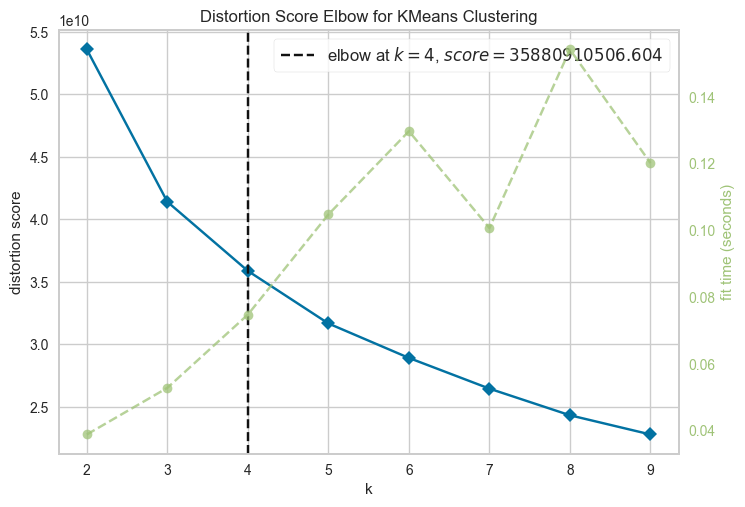

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [192]:
model = KMeans(random_state=42)
distortion_visualizer = KElbowVisualizer(model, k=(2,10))
distortion_visualizer.fit(df1)       
distortion_visualizer.show()    

Silhouette Score (unscaled data) = 0.36217635800391185


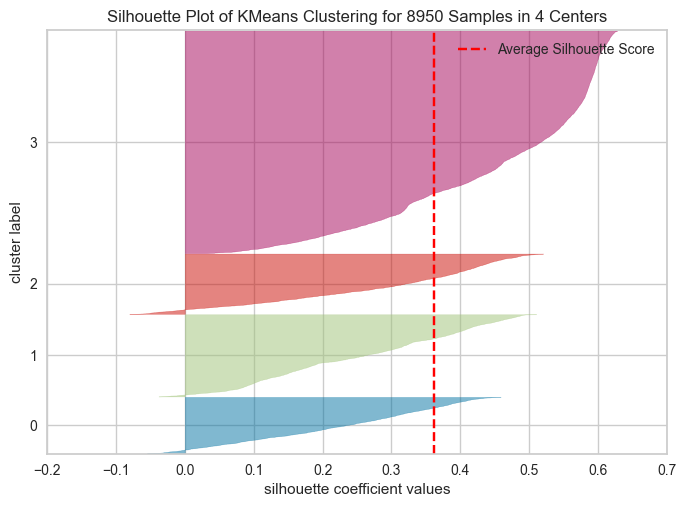

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 8950 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [193]:
km_model = KMeans(distortion_visualizer.elbow_value_, random_state=42)
labels = km_model.fit_predict(df1)
print(f'Silhouette Score (unscaled data) = {silhouette_score(df1, labels)}')
visualizer = SilhouetteVisualizer(km_model, colors='yellowbrick')
visualizer.fit(df1)
df['LABELS'] = labels
visualizer.show()

<AxesSubplot: ylabel='LABELS'>

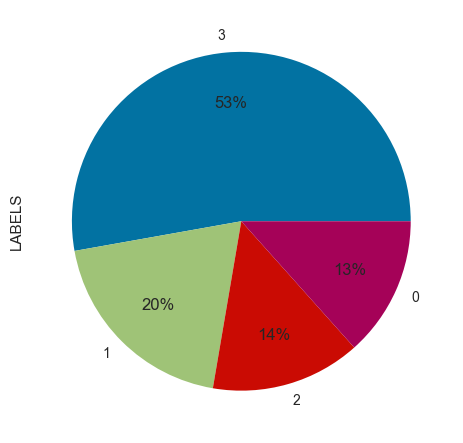

In [194]:
df.LABELS.value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

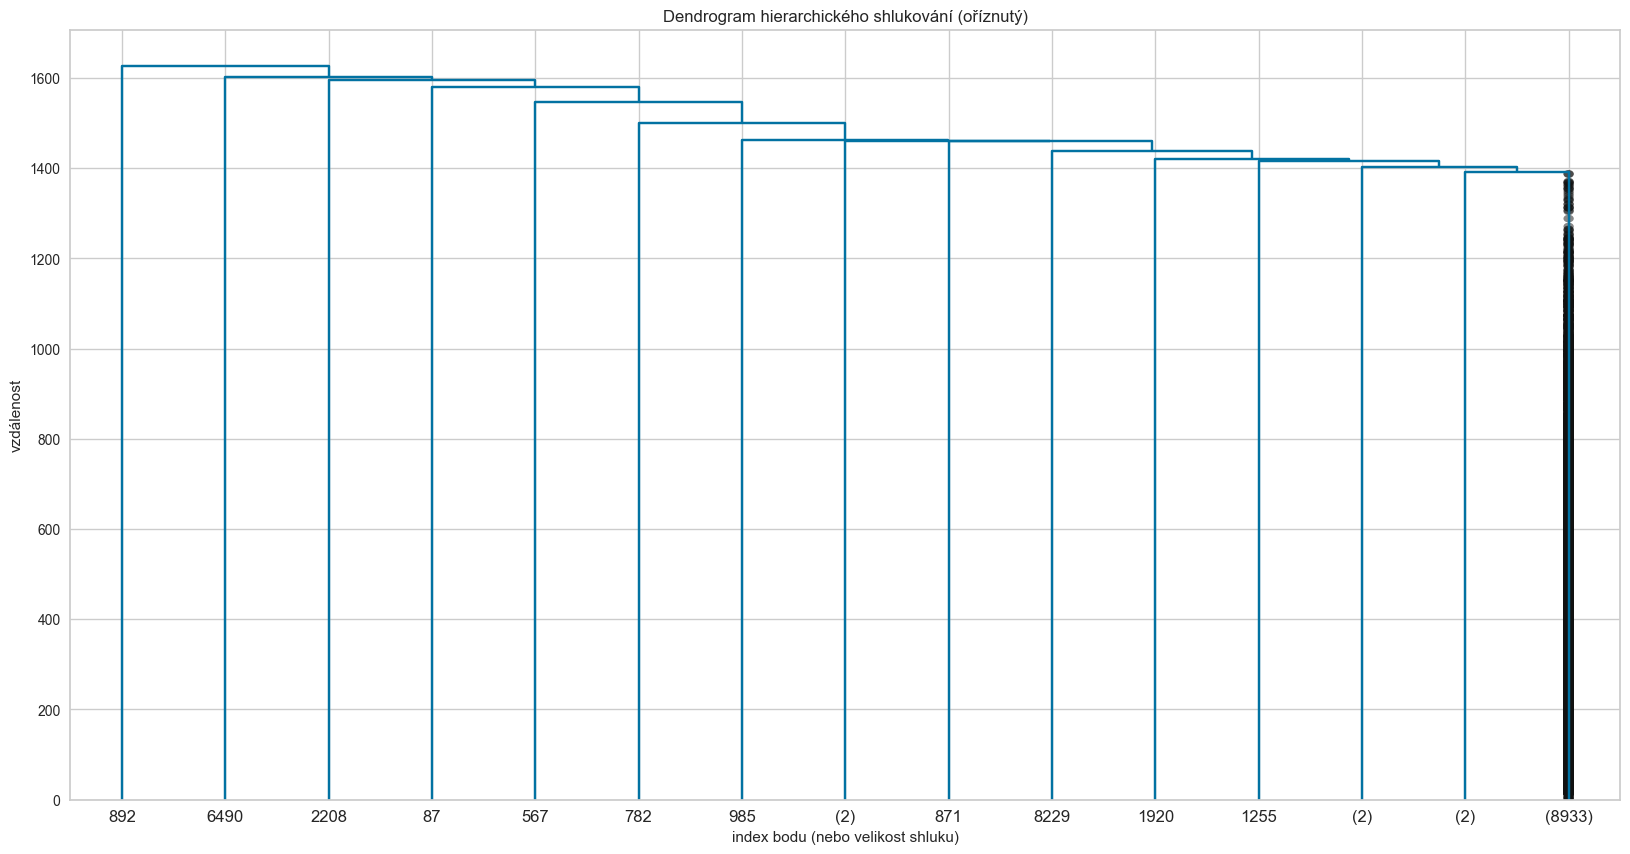

In [195]:
Z = linkage(df1, method="single", metric="euclidean")

plt.figure(figsize=(20, 10))
plt.title("Dendrogram hierarchického shlukování (oříznutý)")
plt.xlabel("index bodu (nebo velikost shluku)")
plt.ylabel("vzdálenost")

dendrogram(
    Z,
    truncate_mode="lastp",
    p=15,
    orientation="top",
    show_contracted=True,
)

plt.show()

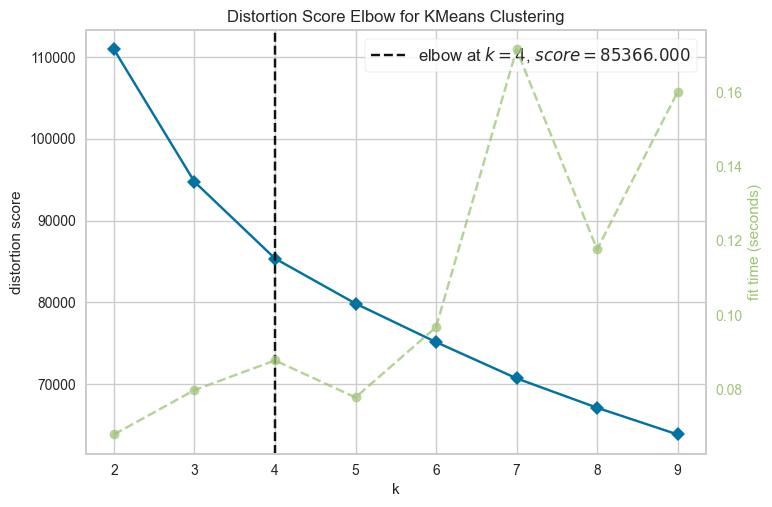

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [196]:
model = KMeans(random_state=42)
distortion_visualizer = KElbowVisualizer(model, k=(2,10))
distortion_visualizer.fit(std_scaled)       
distortion_visualizer.show()    

Silhouette Score (standard scaler) = 0.17444552186819787


c:\Users\Brumda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


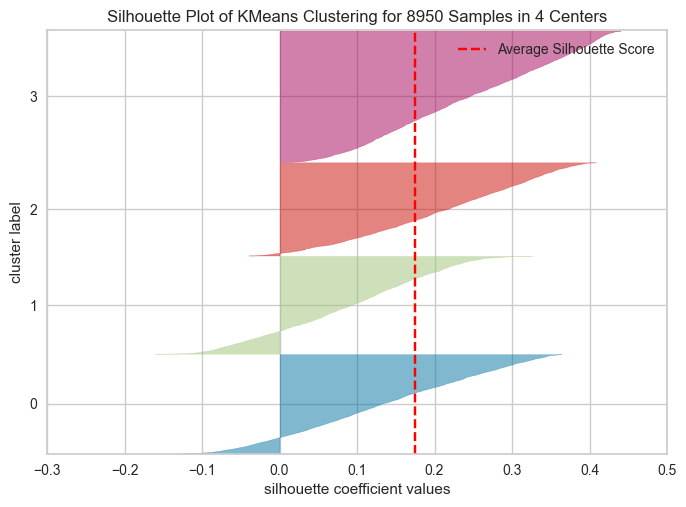

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 8950 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [197]:
km_model = KMeans(distortion_visualizer.elbow_value_, random_state=42)
labels = km_model.fit_predict(std_scaled)
print(f'Silhouette Score (standard scaler) = {silhouette_score(std_scaled, labels)}')
visualizer = SilhouetteVisualizer(km_model, colors='yellowbrick')
visualizer.fit(std_scaled)
std_scaled['LABELS'] = labels
visualizer.show()

<AxesSubplot: ylabel='LABELS'>

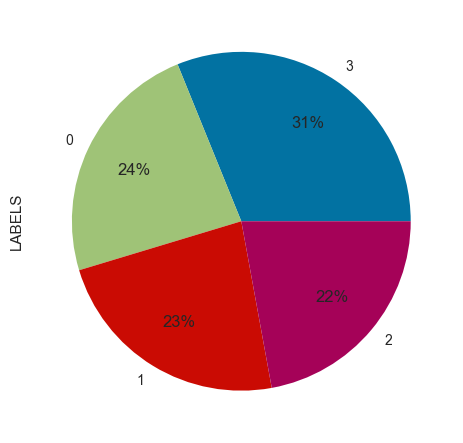

In [198]:
std_scaled.LABELS.value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

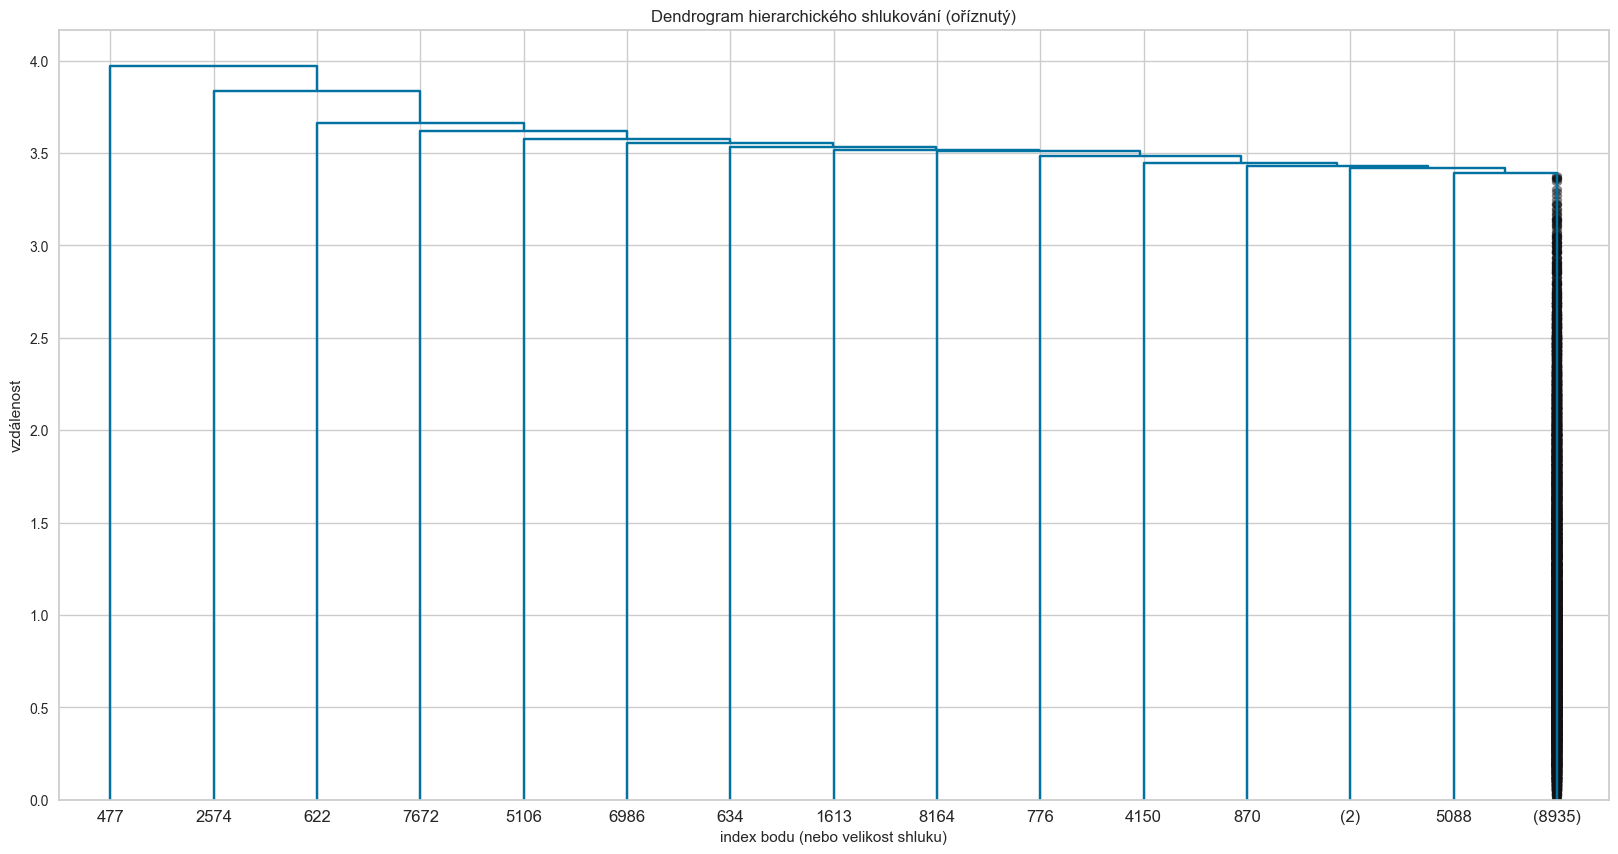

In [199]:
Z = linkage(std_scaled.to_numpy(), method="single", metric="euclidean")

plt.figure(figsize=(20, 10))
plt.title("Dendrogram hierarchického shlukování (oříznutý)")
plt.xlabel("index bodu (nebo velikost shluku)")
plt.ylabel("vzdálenost")

dendrogram(
    Z,
    truncate_mode="lastp",
    p=15,
    orientation="top",
    show_contracted=True,
)

plt.show()

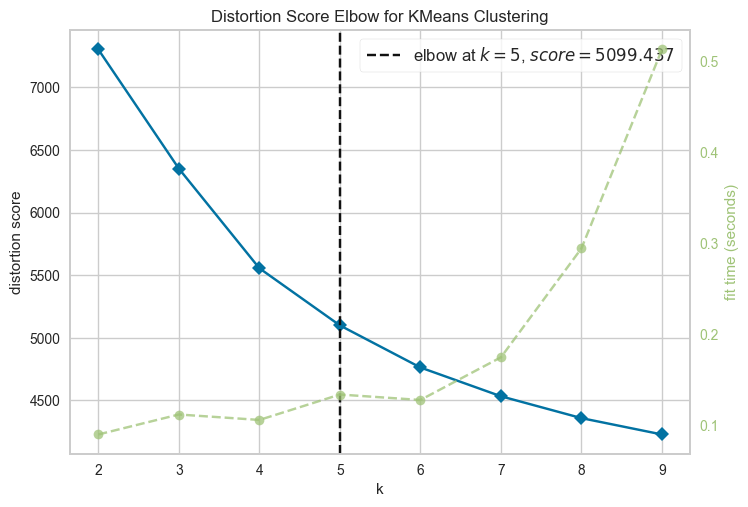

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [200]:
model = KMeans(random_state=42)
distortion_visualizer = KElbowVisualizer(model, k=(2,10))
distortion_visualizer.fit(mm_scaled)       
distortion_visualizer.show()  

Silhouette Score (min_max scaler) = 0.20866355168794395


c:\Users\Brumda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


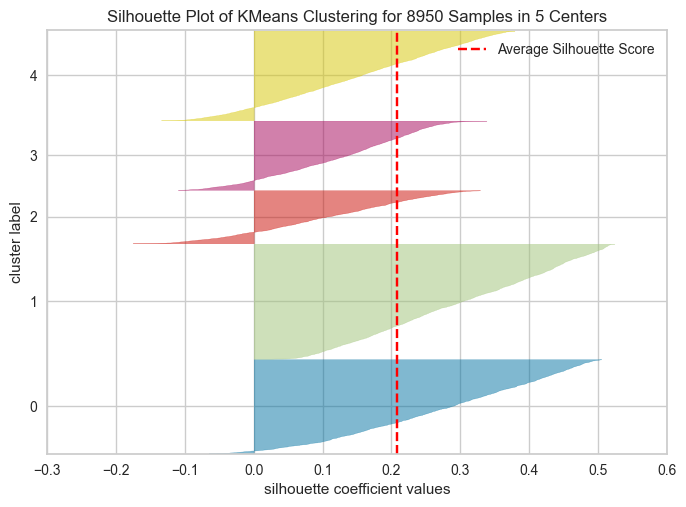

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 8950 Samples in 5 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [201]:
km_model = KMeans(distortion_visualizer.elbow_value_, random_state=42)
labels = km_model.fit_predict(mm_scaled)
print(f'Silhouette Score (min_max scaler) = {silhouette_score(mm_scaled, labels)}')
visualizer = SilhouetteVisualizer(km_model, colors='yellowbrick')
visualizer.fit(mm_scaled)
mm_scaled['LABELS'] = labels
visualizer.show()

<AxesSubplot: ylabel='LABELS'>

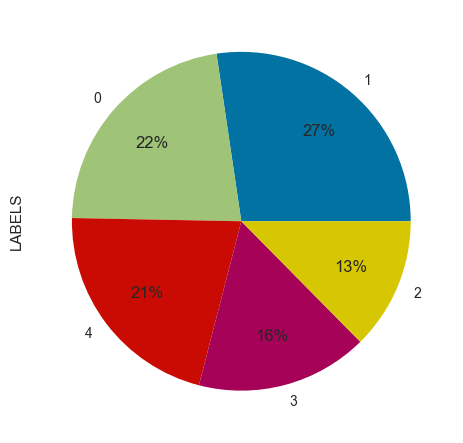

In [202]:
mm_scaled.LABELS.value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

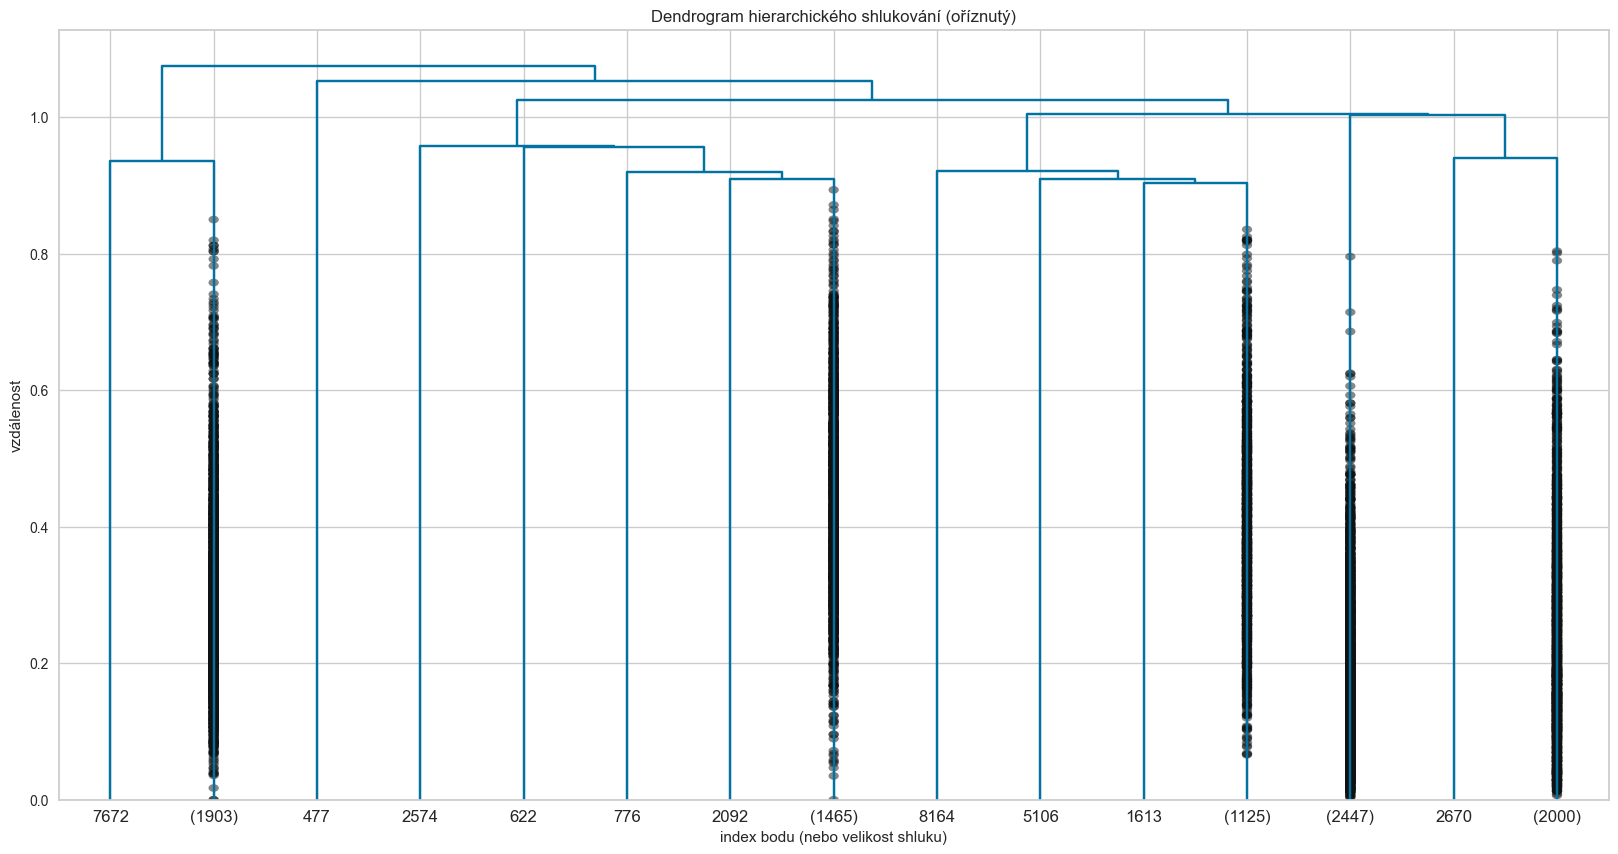

In [203]:
Z = linkage(mm_scaled.to_numpy(), method="single", metric="euclidean")

plt.figure(figsize=(20, 10))
plt.title("Dendrogram hierarchického shlukování (oříznutý)")
plt.xlabel("index bodu (nebo velikost shluku)")
plt.ylabel("vzdálenost")

dendrogram(
    Z,
    truncate_mode="lastp",
    p=15,
    orientation="top",
    show_contracted=True,
)

plt.show()

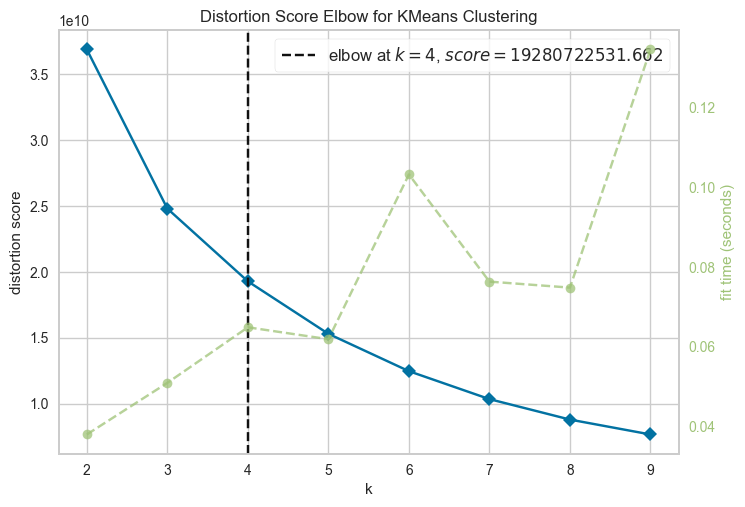

<AxesSubplot: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [204]:
model = KMeans(random_state=42)
distortion_visualizer = KElbowVisualizer(model, k=(2,10))
distortion_visualizer.fit(pca_data)       
distortion_visualizer.show()    

Silhouette Score (min_max scaler) = 0.4857756428275181


c:\Users\Brumda\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but KMeans was fitted with feature names
  warnings.warn(


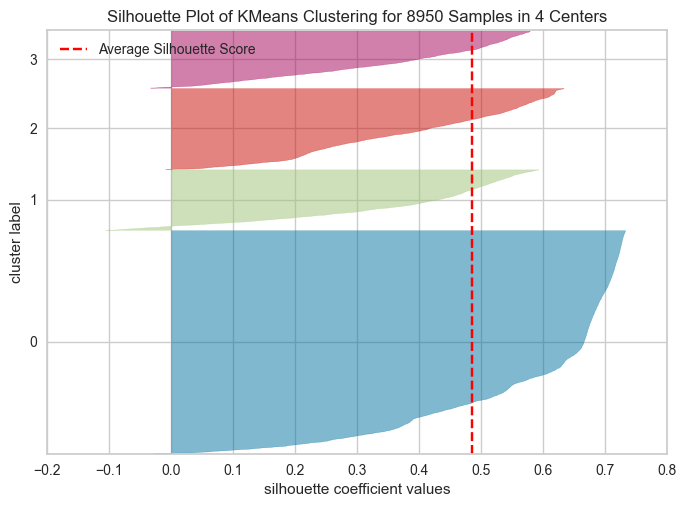

<AxesSubplot: title={'center': 'Silhouette Plot of KMeans Clustering for 8950 Samples in 4 Centers'}, xlabel='silhouette coefficient values', ylabel='cluster label'>

In [205]:
km_model = KMeans(distortion_visualizer.elbow_value_, random_state=42)
labels = km_model.fit_predict(pca_data)
print(f'Silhouette Score (min_max scaler) = {silhouette_score(pca_data, labels)}')
visualizer = SilhouetteVisualizer(km_model, colors='yellowbrick')
visualizer.fit(pca_data)
pca_data['LABELS'] = labels
visualizer.show()

<AxesSubplot: ylabel='LABELS'>

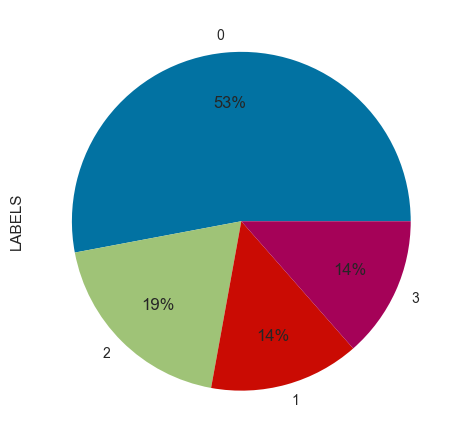

In [206]:
pca_data.LABELS.value_counts().plot.pie(autopct='%1.0f%%', pctdistance=0.7, labeldistance=1.1)

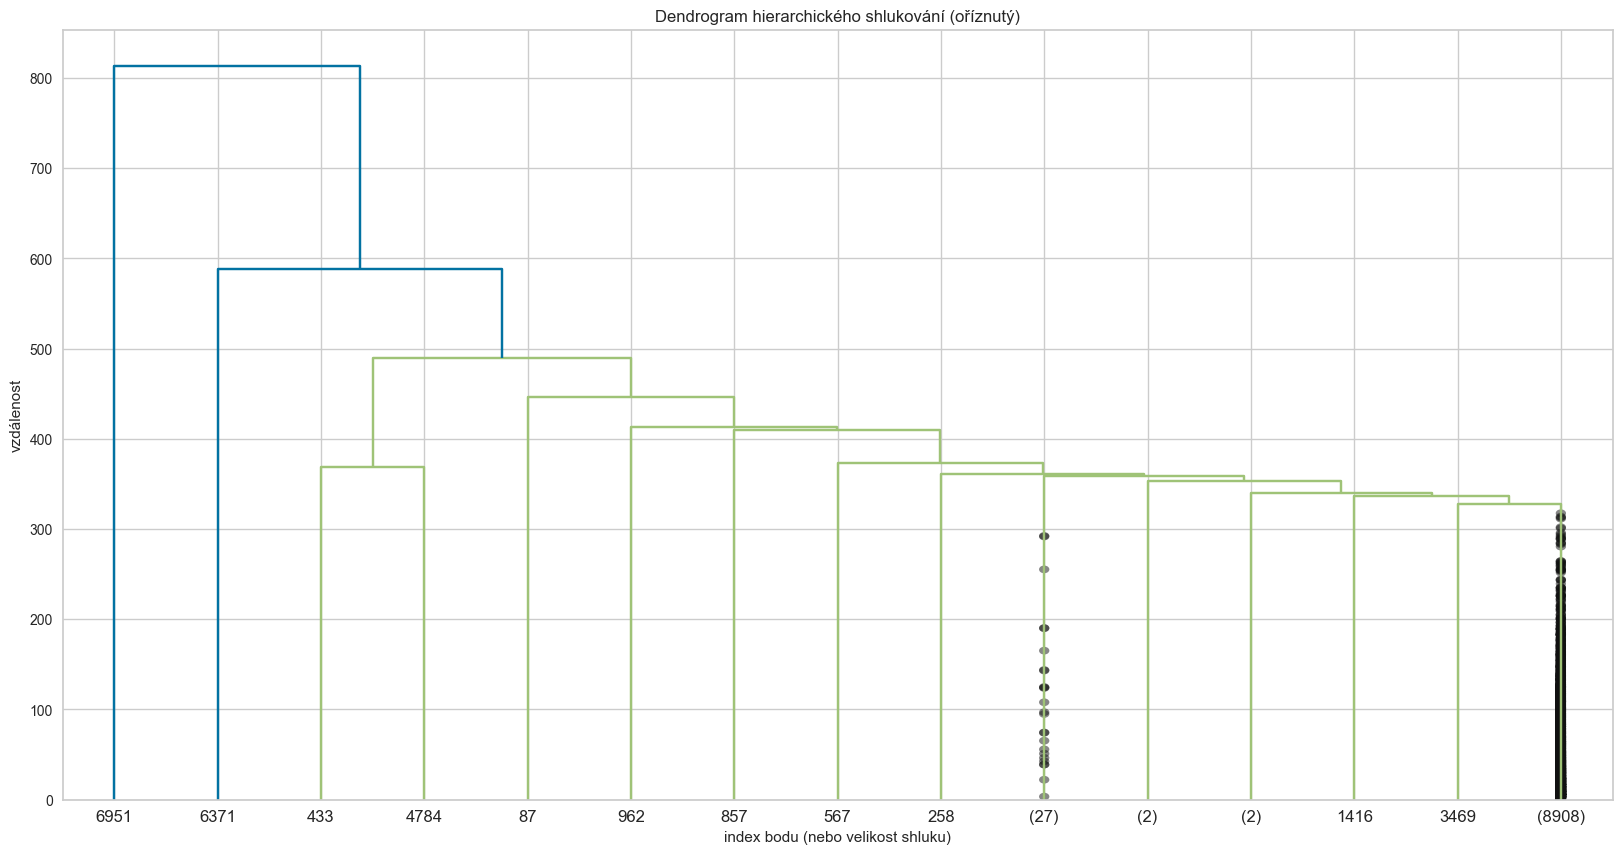

In [207]:
Z = linkage(pca_data.to_numpy(), method="single", metric="euclidean")

plt.figure(figsize=(20, 10))
plt.title("Dendrogram hierarchického shlukování (oříznutý)")
plt.xlabel("index bodu (nebo velikost shluku)")
plt.ylabel("vzdálenost")

dendrogram(
    Z,
    truncate_mode="lastp",
    p=15,
    orientation="top",
    show_contracted=True,
)

plt.show()

I'll use the model with standard scaling as it has the most uniform spread in the clusters. The second best for me would be the min-max one, but there are two significantly smaller clusters and one bigger

In [208]:
class0 = std_scaled[std_scaled["LABELS"] == 0]
class1 = std_scaled[std_scaled["LABELS"] == 1]
class2 = std_scaled[std_scaled["LABELS"] == 2]
class3 = std_scaled[std_scaled["LABELS"] == 3]

In [209]:
def spider_plot_all(data, title):
    means = data.groupby("LABELS").mean().to_numpy()
    names = data.columns[:-1]
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(names), endpoint=False)
    categories = np.arange(0, len(means))
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(12,12))
    for i in range(len(means)):
        plt.plot(label_loc, means[i], label=f'class {categories[i]}')
    
    plt.title(f'Feature comparison ({title})', size=20)
    (lines, labels) = plt.thetagrids(np.degrees(label_loc), labels=names)
    plt.legend()
    plt.show()

This graph is fascinating. But let's be honest. It is also hard to navigate. I'm going to split it for each class, but I still want to keep this one because here we can compare the classes among each other.

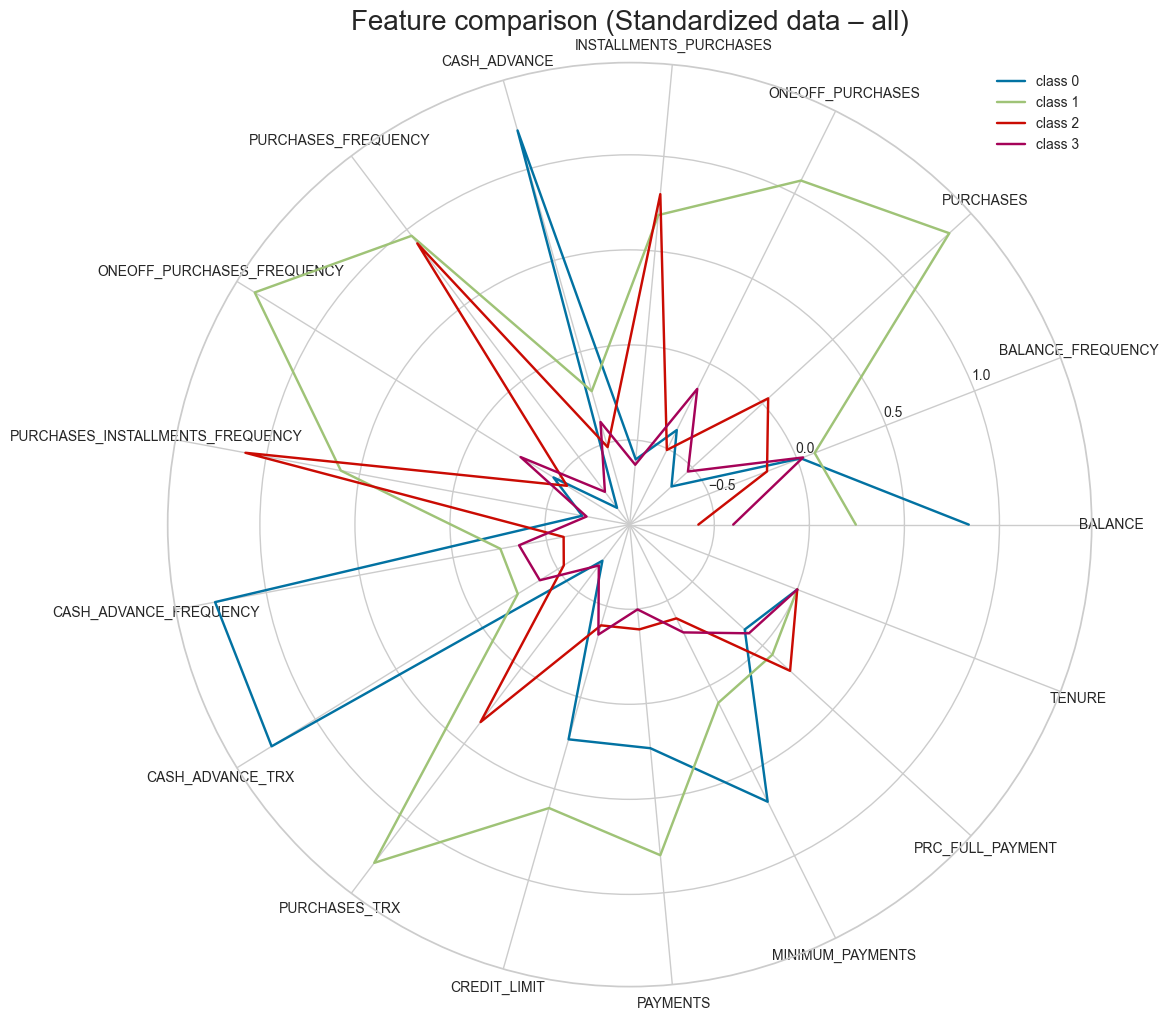

In [210]:
spider_plot_all(std_scaled, 'Standardized data – all')

In [211]:
def spider_plot(data, title):
    means = data.mean().to_numpy()
    names = data.columns[:]
    label_loc = np.linspace(start=0, stop=2 * np.pi, num=len(names), endpoint=False)
    fig, ax = plt.subplots(subplot_kw={'projection': 'polar'}, figsize=(12,12))
    for i in range(1, len(means)):
        plt.plot(label_loc, means, "b")
    
    plt.title(f'Feature comparison ({title})', size=20)
    (lines, labels) = plt.thetagrids(np.degrees(label_loc), labels=names)
    plt.show()

Class 0 is kind of weird. They have the most balance by a longshot, they use mainly cash in advance, yet they don't purchase almost anything (at least not with their credit card).

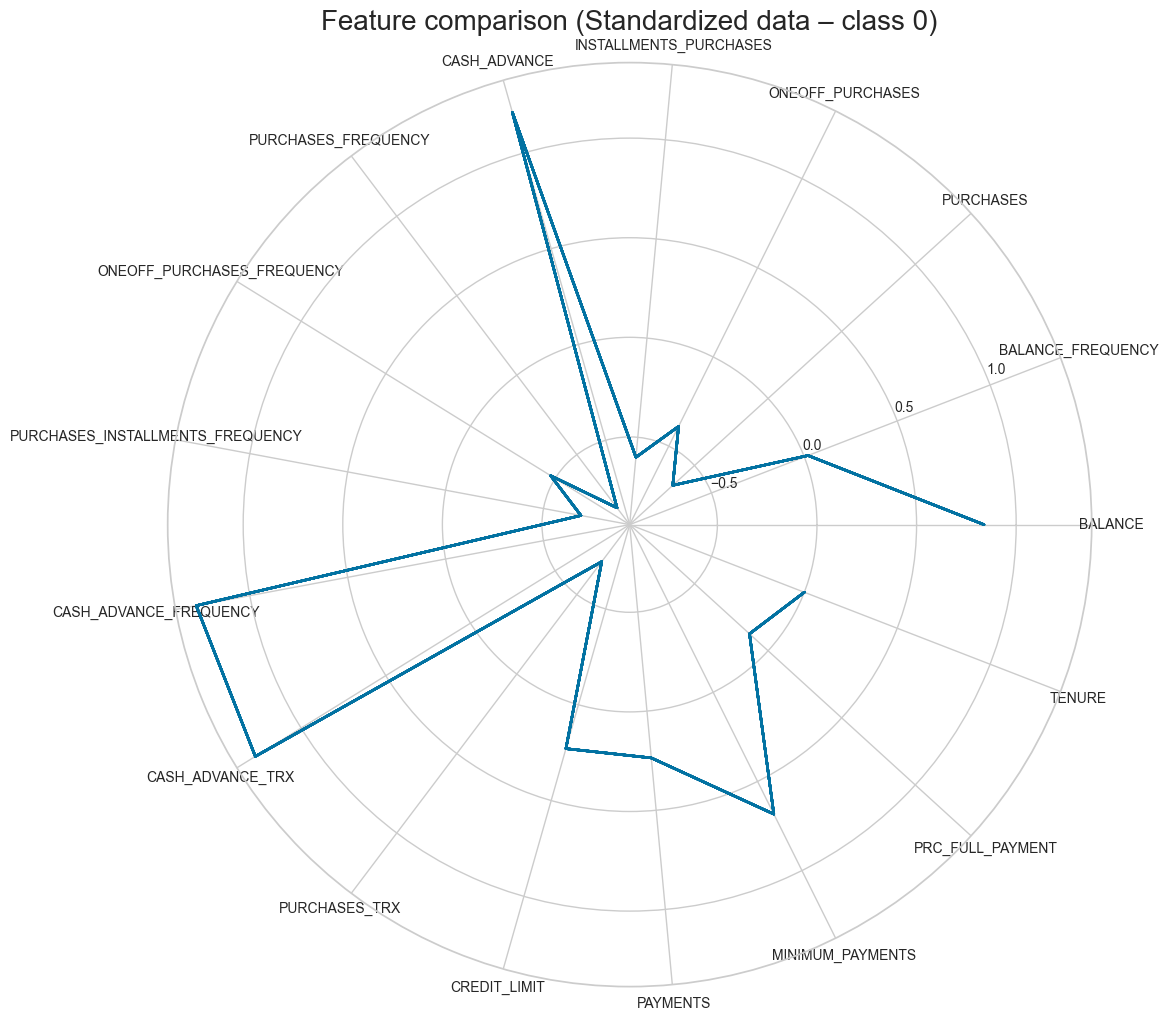

In [212]:
spider_plot(class0.drop(columns="LABELS"), 'Standardized data – class 0')

Class 1 looks like the average upper middle class. They have the second highest balance, they don't use cash, and they buy a lot of things (the most of all - around three times more than the second highest)

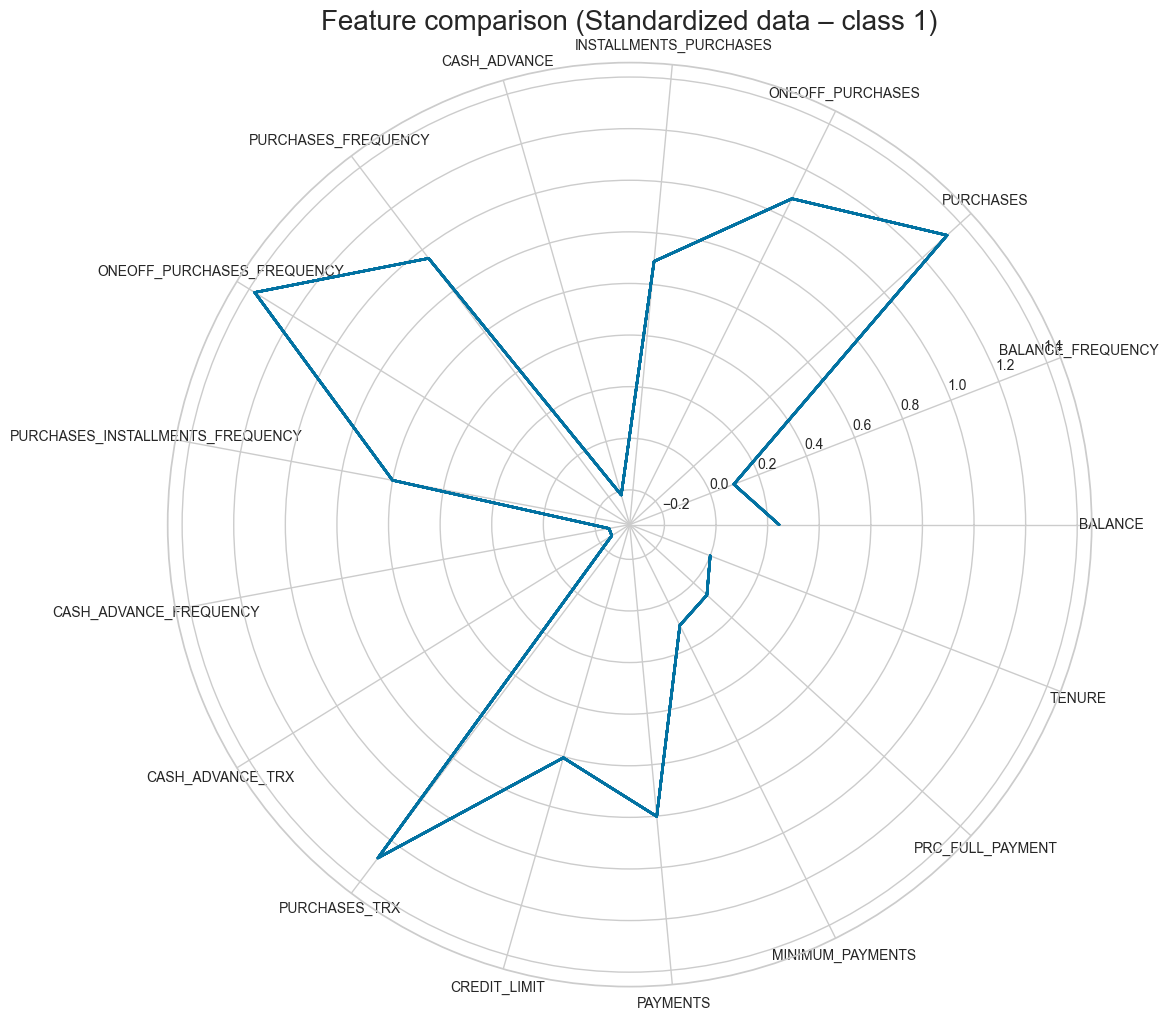

In [213]:
spider_plot(class1.drop(columns="LABELS"), 'Standardized data – class 1')

Class 2 is kind of sad. They don't have any money (lowest balance), but it doesn't prevent them from spending it. They can!t afford to buy things in one-off purchases, so they use instalments. And they use it a lot.

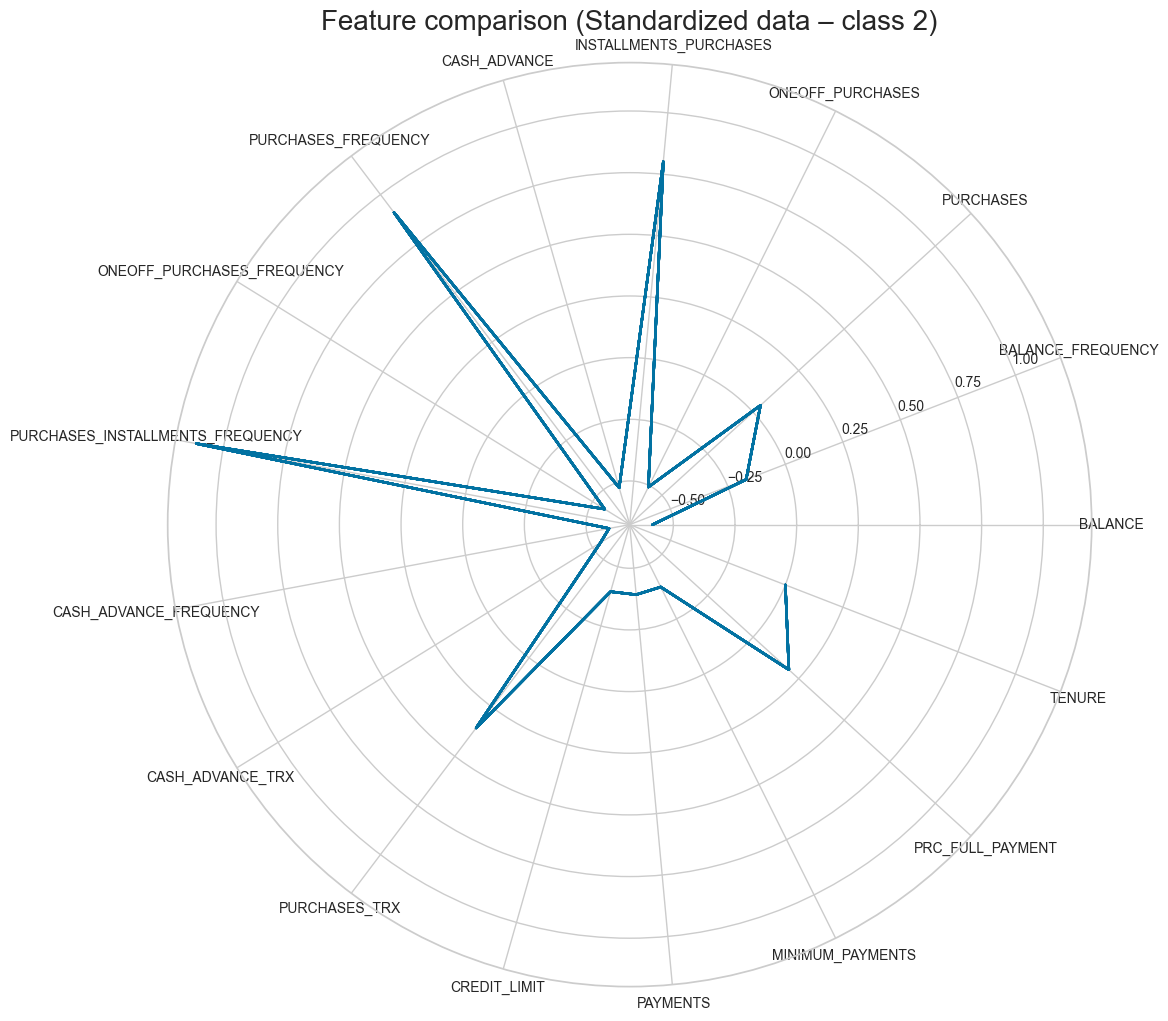

In [214]:
spider_plot(class2.drop(columns="LABELS"), 'Standardized data – class 2')

Class 3 is similar to class 2. There is an essential difference. These people don't have much money, but instead of spending it anyway, they try to keep it. This results in a higher balance, but at the cost of not owning as much other stuff.

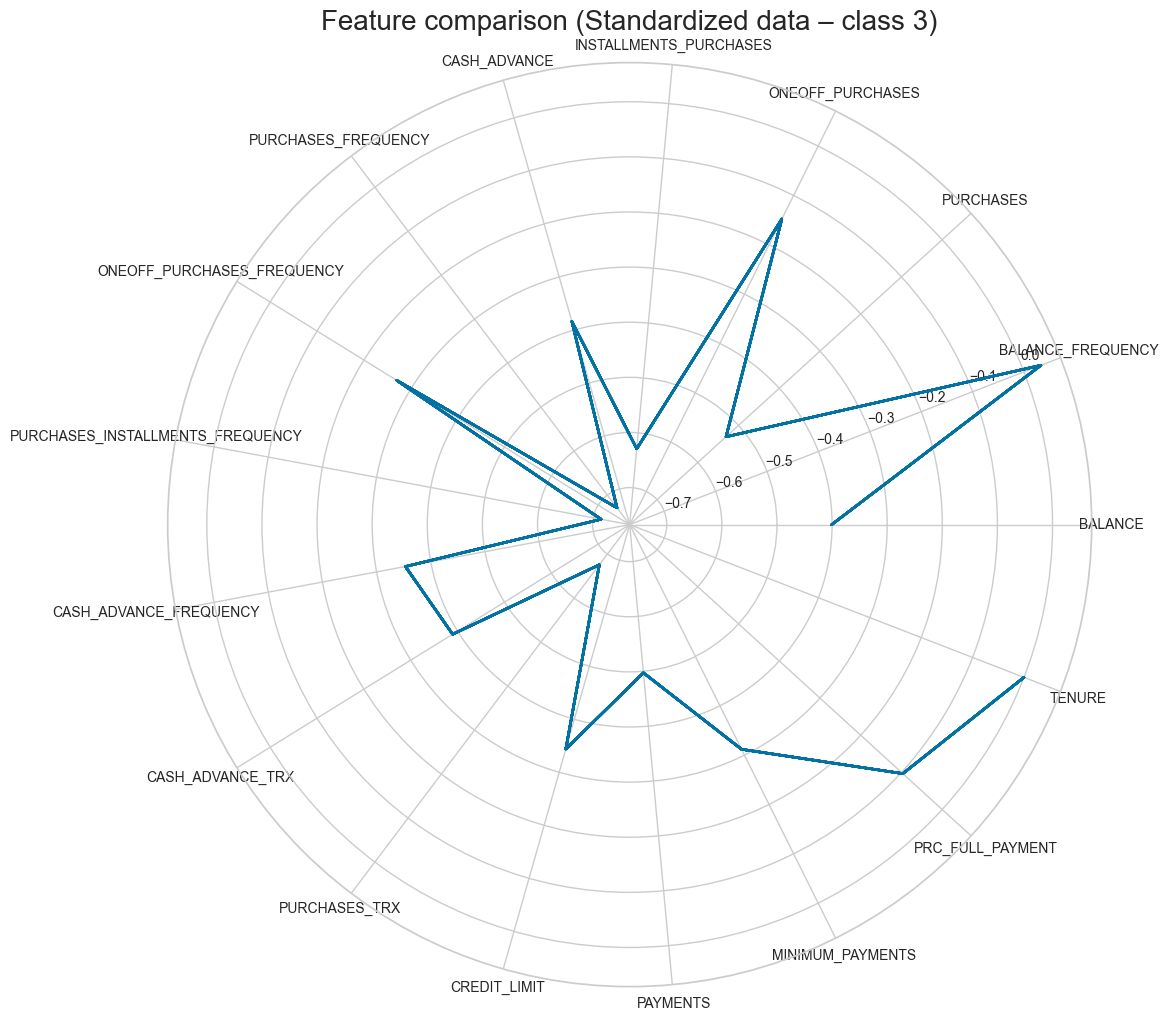

In [215]:
spider_plot(class3.drop(columns="LABELS"), 'Standardized data – class 3')